### Import & Data Load

In [2]:
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
TRAIN_CSV = r"D:\새 폴더 (2)\LGAimers\open\train.csv"
TEST_CSV  = r"D:\새 폴더 (2)\LGAimers\open\test.csv"

train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

In [3]:
train.head(5)

,ID,gender,age,height,weight,cholesterol,systolic_blood_pressure,diastolic_blood_pressure,glucose,bone_density,activity,smoke_status,medical_history,family_medical_history,sleep_pattern,edu_level,mean_working,stress_score
0,TRAIN_0000,F,72,161.49,58.47,279.84,165,100,143.35,0.87,moderate,ex-smoker,high blood pressure,diabetes,sleep difficulty,bachelors degree,NaN,0.63
1,TRAIN_0001,M,88,179.87,77.60,257.37,178,111,146.94,0.07,moderate,ex-smoker,NaN,diabetes,normal,graduate degree,NaN,0.83
2,TRAIN_0002,M,47,182.47,89.93,226.66,134,95,142.61,1.18,light,ex-smoker,NaN,NaN,normal,high school diploma,9.0,0.70
3,TRAIN_0003,M,69,185.78,68.63,206.74,158,92,137.26,0.48,intense,ex-smoker,high blood pressure,NaN,oversleeping,graduate degree,NaN,0.17
4,TRAIN_0004,F,81,164.63,71.53,255.92,171,116,129.37,0.34,moderate,ex-smoker,diabetes,diabetes,sleep difficulty,bachelors degree,NaN,0.36


### Check Data

In [6]:
train.isnull().sum()

ID                             0
gender                         0
age                            0
height                         0
weight                         0
cholesterol                    0
systolic_blood_pressure        0
diastolic_blood_pressure       0
glucose                        0
bone_density                   0
activity                       0
smoke_status                   0
medical_history             1289
family_medical_history      1486
sleep_pattern                  0
edu_level                    607
mean_working                1032
stress_score                   0
dtype: int64

In [7]:
# 결측값 있는 칼럼(column) 확인
missing_columns_train = train.columns[train.isnull().sum() > 0]
missing_columns_train

Index(['medical_history', 'family_medical_history', 'edu_level',
       'mean_working'],
      dtype='object')

In [8]:
train[missing_columns_train].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   medical_history         1711 non-null   object 
 1   family_medical_history  1514 non-null   object 
 2   edu_level               2393 non-null   object 
 3   mean_working            1968 non-null   float64
dtypes: float64(1), object(3)
memory usage: 93.9+ KB


In [9]:
categorical_na_cols = []
numerical_na_cols = []

# 결측값이 있는 각 칼럼에 대해 데이터 타입 확인
for col in missing_columns_train:
    # 해당 칼럼이 범주형(object 또는 category)인지 확인
    if col in train.select_dtypes(include=['object', 'category']).columns:
        categorical_na_cols.append(col)
    # 해당 칼럼이 수치형(int 또는 float)인지 확인
    elif col in train.select_dtypes(include=['int', 'float']).columns:
        numerical_na_cols.append(col)

print("결측값이 있는 범주형 변수:", categorical_na_cols)
print("결측값이 있는 수치형 변수:", numerical_na_cols)

결측값이 있는 범주형 변수: ['medical_history', 'family_medical_history', 'edu_level']
결측값이 있는 수치형 변수: ['mean_working']


### Data Preprocessing

In [10]:
# 범주형 변수의 결측값을 최빈값으로 대체
for col in categorical_na_cols:
    # 학습 데이터에서 최빈값 계산
    most_frequent = train[col].mode()[0]
    
    # 학습 데이터와 테스트 데이터 모두 해당 칼럼의 최빈값으로 대체
    train[col] = train[col].fillna(most_frequent)
    test[col] = test[col].fillna(most_frequent)

In [11]:
# mean_working에 대해 중앙값 대체
median_value = train['mean_working'].median()

train['mean_working'] = train['mean_working'].fillna(median_value)
test['mean_working'] = test['mean_working'].fillna(median_value)

In [12]:
# Label Encoding 적용 열 - 범주형 데이터
categorical_cols = train.select_dtypes(include='object').columns.drop('ID')

for feature in categorical_cols:
    le = LabelEncoder()
    le = le.fit(train[feature])
    train[feature] = le.transform(train[feature])
    
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    
    test[feature] = le.transform(test[feature])

In [13]:
x_train = train.drop(['ID', 'stress_score'], axis = 1)
y_train = train['stress_score']

test = test.drop('ID', axis = 1)

### Train / Predict

In [14]:
model = LGBMRegressor(random_state = 42)
model.fit(x_train, y_train)

pred = model.predict(test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1454
[LightGBM] [Info] Number of data points in the train set: 3000, number of used features: 16
[LightGBM] [Info] Start training from score 0.482130


### Submission

In [16]:
submission = pd.read_csv('sample_submission.csv')

In [17]:
submission['stress_score'] = pred
submission.head()

,ID,stress_score
0,TEST_0000,0.412394
1,TEST_0001,0.689009
2,TEST_0002,0.183309
3,TEST_0003,0.522015
4,TEST_0004,0.572112


In [18]:
submission.to_csv('submit.csv', index=False)

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

In [ ]:
y_binned = pd.qcut(y_train, q = 5, labels=False) # y_train 값을 5개의 동일 크기 구간으로 나눠서 stratify용 레이블 생성

skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42) # Stratified K-Fold 설정: 5 폴드, 데이터 분포를 유지하며 섞기

rmse_scores = []

for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y_binned), 1): # 각 fold별 학습 & 검증
    X_tr, X_val = train.iloc[tr_idx], x_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[tr_idx], y_train.iloc[val_idx]
    # tr_idx에는 4개의 폴드 인덱스(학습셋) val_idx에는 1개의 폴드 인덱스(검증셋)
    # 5번 반복 시 데이터의 모든 부분을 한번씩 검증셋 역할(5Fold 교차검증)

    model =LGBMRegressor(
        n_estimators = 1000, # 최대 트리 개수
        learning_rate = 0.05,# 학습률
        num_leaves = 31, # 하나의 트리에서 최대 잎 수
        feature_fraction = 0.8, # 피처 샘플링 비율
        bagging_fraction = 0.8, #데이터 샘플링 비율
        random_state = 42 # 재현성 고정 
    )
# 학습: 검증셋을 두고 RMSE 기준으로 50회 개선 없으면 중단
model.fit(
    X_tr, y_tr,
    eval_set = [(X_val, y_val)],
    eval_metric = 'rmse',
    callbacks = [
        lgb.early_stopping(stopping_rounds = 50),
        lgb.log_evaluation(period = 0)
    ]
)
# 검증 예측 및 RMSE 계산 
val_pred = model.predict(X_val, num_iteration = model.best_iteration_)

mse = mean_squared_error(y_val, val_pred) #MSE 계산
rmse = np.sqrt(mse) # RMSE로 변환
rmse_scores.append(rmse)
print(f'Fold {fold} RMSE: {rmse:.4f}')

# 전체 폴드 평균, 표준편차 출력
print(f'\nCV RMSE Mean: {np.mean(rmse_scores):.4f} Std: {np.std(rmse_scores):.4f}')

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1446
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 16
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fr

In [30]:
# 3) X_train, y_train, X_test 정의
X_train = train.drop(['ID', 'stress_score'], axis=1)
y_train = train['stress_score']

# 4) 단일 모델 교차검증 (여기까지 코드 동일)
# … (qcut → StratifiedKFold → for fold …)

# 5) 최종 모델 학습
final_model = LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    random_state=42
)
final_model.fit(X_train, y_train)

# 6) 테스트 예측 & 파일 생성
preds = final_model.predict(test)
submission['stress_score'] = preds
submission.to_csv('submission.csv', index=False)

print(submission.head())

          ID  stress_score
0  TEST_0000      0.611864
1  TEST_0001      0.894817
2  TEST_0002      0.142788
3  TEST_0003      0.455228
4  TEST_0004      0.595268


In [4]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import ace_tools

# Assuming 'train' and 'test' DataFrames are already loaded in the environment
# If not, you can uncomment and adjust these lines:
# train = pd.read_csv(TRAIN_CSV)
# test  = pd.read_csv(TEST_CSV)

# 1. Encode sleep_pattern
sleep_map = {'undersleep': 0, 'normal': 1, 'oversleep': 2}
train['sleep_code'] = train['sleep_pattern'].map(sleep_map)
test['sleep_code']  = test['sleep_pattern'].map(sleep_map)

# 2. Prepare clustering data (handle missing)
X_cluster = train[['sleep_code', 'mean_working']].fillna(-1)
X_cluster_test = test[['sleep_code', 'mean_working']].fillna(-1)

# 3. KMeans clustering into 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
train['work_sleep_cluster'] = kmeans.fit_predict(X_cluster)
test['work_sleep_cluster']  = kmeans.predict(X_cluster_test)

# 4. Display cluster centers
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=['sleep_code', 'mean_working'])
ace_tools.display_dataframe_to_user("Cluster Centers", cluster_centers)

# 5. Show a sample of the new feature
sample = train[['sleep_pattern', 'mean_working', 'work_sleep_cluster']].head(10)
ace_tools.display_dataframe_to_user("Sample Cluster Labels", sample)

ModuleNotFoundError: No module named 'ace_tools'

In [5]:
import pandas as pd
from sklearn.cluster import KMeans

# 1) sleep_pattern을 숫자로 인코딩
sleep_map = {'적게 잠': 0, '평균': 1, '많이 잠': 2}
train['sleep_code'] = train['sleep_pattern'].map(sleep_map)
test ['sleep_code'] = test ['sleep_pattern'].map(sleep_map)

# 2) 클러스터링에 사용할 두 개 칼럼(결측은 -1로 대체)
X_cluster_train = train[['sleep_code', 'mean_working']].fillna(-1)
X_cluster_test  = test [['sleep_code', 'mean_working']].fillna(-1)

# 3) KMeans로 3개 군집 생성 (임의 설정)
kmeans = KMeans(n_clusters=3, random_state=42)
train['work_sleep_cluster'] = kmeans.fit_predict(X_cluster_train)
test ['work_sleep_cluster'] = kmeans.predict(X_cluster_test)

# 4) 군집별 중심 확인 (디버깅용)
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=['sleep_code','mean_working']
)
print("Cluster centers:\n", centers)

# 5) 군집별 데이터 개수 확인
print("Counts per cluster:\n", train['work_sleep_cluster'].value_counts())

# 이제 train, test에 추가된 work_sleep_cluster를 기존 피처와 함께 모델에 넣으면 됩니다.


Cluster centers:
    sleep_code  mean_working
0        -1.0      7.965614
1        -1.0     -1.000000
2        -1.0     10.688766
Counts per cluster:
 work_sleep_cluster
0    1425
1    1032
2     543
Name: count, dtype: int64


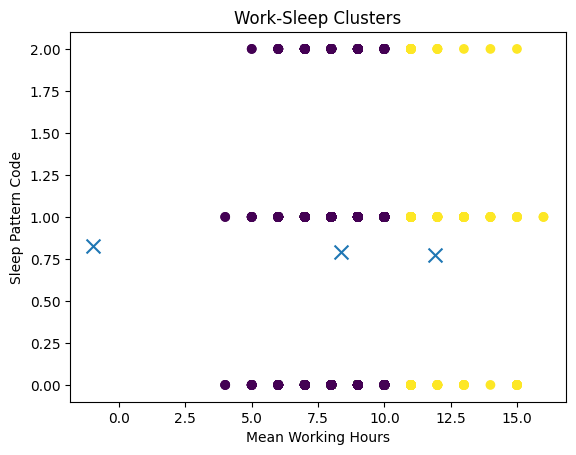

In [9]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1) 데이터 로드 (작업 디렉토리에 train.csv가 있다고 가정)
#train_df = pd.read_csv('/mnt/data/train.csv')

# 2) sleep_pattern을 숫자로 인코딩
sleep_map = {'sleep difficulty': 0, 'normal': 1, 'oversleeping': 2}
train['sleep_code'] = train['sleep_pattern'].map(sleep_map)

# 3) 클러스터링에 사용할 데이터 준비 (결측값 -1로 대체)
X = train[['sleep_code', 'mean_working']].fillna(-1)

# 4) KMeans 클러스터링 수행 (n_clusters=3)
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X)
train['work_sleep_cluster'] = labels

# 5) 산점도(클러스터 시각화)
plt.figure()
plt.scatter(train['mean_working'], train['sleep_code'], c=labels)
# 군집 중심 표시 (X 표시)
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], marker='x', s=100)
plt.xlabel('Mean Working Hours')
plt.ylabel('Sleep Pattern Code')
plt.title('Work-Sleep Clusters')
plt.show()


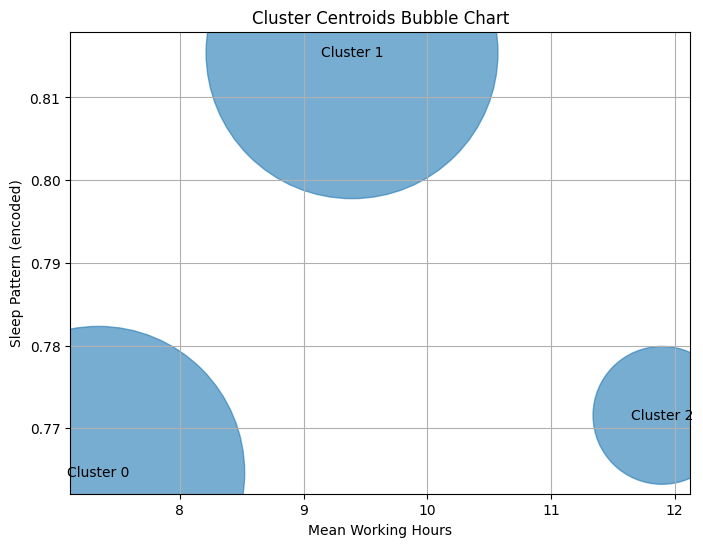

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


# 2) 수면 패턴과 평균 근무 시간 선택 및 전처리
df = train[['sleep_pattern', 'mean_working']].copy()
# 범주형 sleep_pattern을 숫자로 인코딩
df['sleep_code'] = pd.factorize(df['sleep_pattern'])[0]
df = df.dropna(subset=['mean_working', 'sleep_code'])

# 3) KMeans 클러스터링 (클러스터 개수는 3으로 설정)
X = df[['mean_working', 'sleep_code']]
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# 4) 군집 중심 및 크기 계산
centroids = kmeans.cluster_centers_
counts = df['cluster'].value_counts().sort_index()

# 5) 버블 차트 생성: 중심 위치(x,y)에 클러스터 크기 비례 버블
plt.figure(figsize=(8, 6))
plt.scatter(centroids[:, 0], centroids[:, 1], s=counts.values * 50, alpha=0.6)
for i, (x, y) in enumerate(centroids):
    plt.text(x, y, f'Cluster {i}', ha='center', va='center')

plt.xlabel('Mean Working Hours')
plt.ylabel('Sleep Pattern (encoded)')
plt.title('Cluster Centroids Bubble Chart')
plt.grid(True)
plt.show()


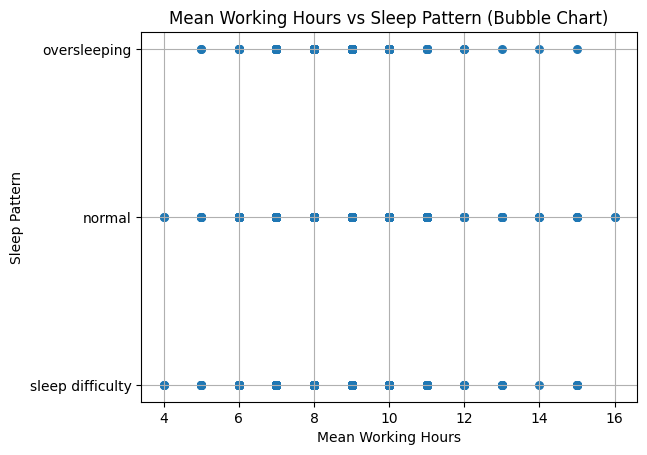

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) train.csv 파일 경로를 지정하세요 (현재 디렉토리에 train.csv가 있어야 합니다)

# 2) sleep_pattern과 mean_working만 추출하고 결측값 제거
df = df[['sleep_pattern', 'mean_working']].dropna()

# 3) sleep_pattern을 숫자로 인코딩
#    데이터에 따라 키-값을 수정하세요
mapping = {'sleep difficulty': 0, 'normal': 1, 'oversleeping': 2}
df['sleep_code'] = df['sleep_pattern'].map(mapping)

# 4) 버블 차트 그리기
plt.figure()
plt.scatter(df['mean_working'], df['sleep_code'], s=30)
plt.yticks(list(mapping.values()), list(mapping.keys()))
plt.xlabel('Mean Working Hours')
plt.ylabel('Sleep Pattern')
plt.title('Mean Working Hours vs Sleep Pattern (Bubble Chart)')
plt.grid(True)
plt.show()


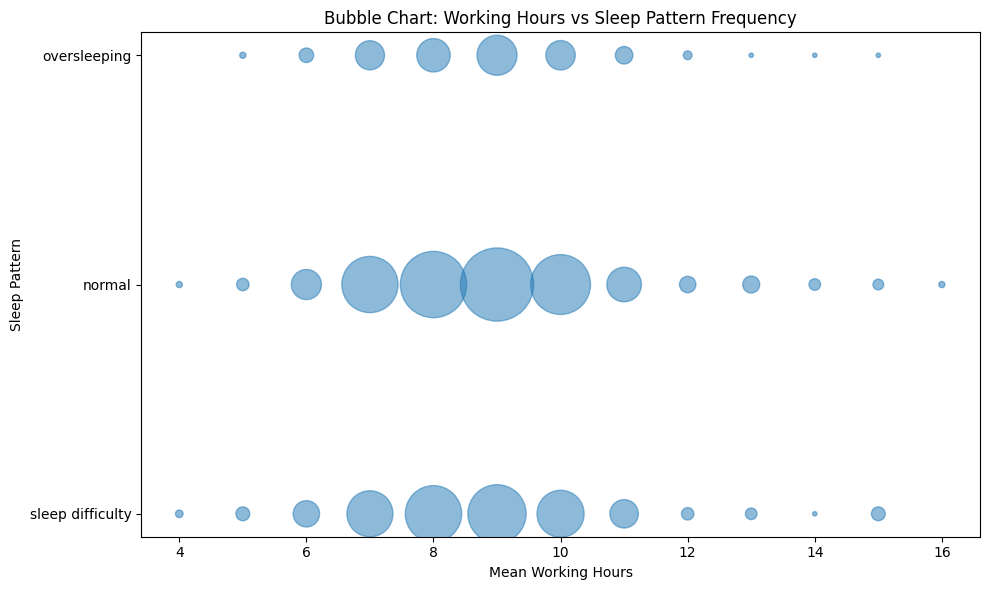

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (필요시 경로를 조정하세요)
#train = pd.read_csv('train.csv')

# 사용할 칼럼 선택 및 결측치 제거
df = train[['mean_working', 'sleep_pattern']].dropna()

# 수면 패턴을 수치로 매핑
mapping = {'sleep difficulty': 0, 'normal': 1, 'oversleeping': 2}
df['sleep_numeric'] = df['sleep_pattern'].map(mapping)

# 평균 근무 시간과 수면 패턴별 빈도 계산
grouped = df.groupby(['mean_working', 'sleep_pattern']).size().reset_index(name='count')
grouped['sleep_numeric'] = grouped['sleep_pattern'].map(mapping)

# 버블 차트 그리기
plt.figure(figsize=(10, 6))
plt.scatter(
    grouped['mean_working'], 
    grouped['sleep_numeric'], 
    s=grouped['count'] * 10,  # bubble 크기 조정
    alpha=0.5
)
plt.yticks(list(mapping.values()), list(mapping.keys()))
plt.xlabel('Mean Working Hours')
plt.ylabel('Sleep Pattern')
plt.title('Bubble Chart: Working Hours vs Sleep Pattern Frequency')
plt.tight_layout()
plt.show()


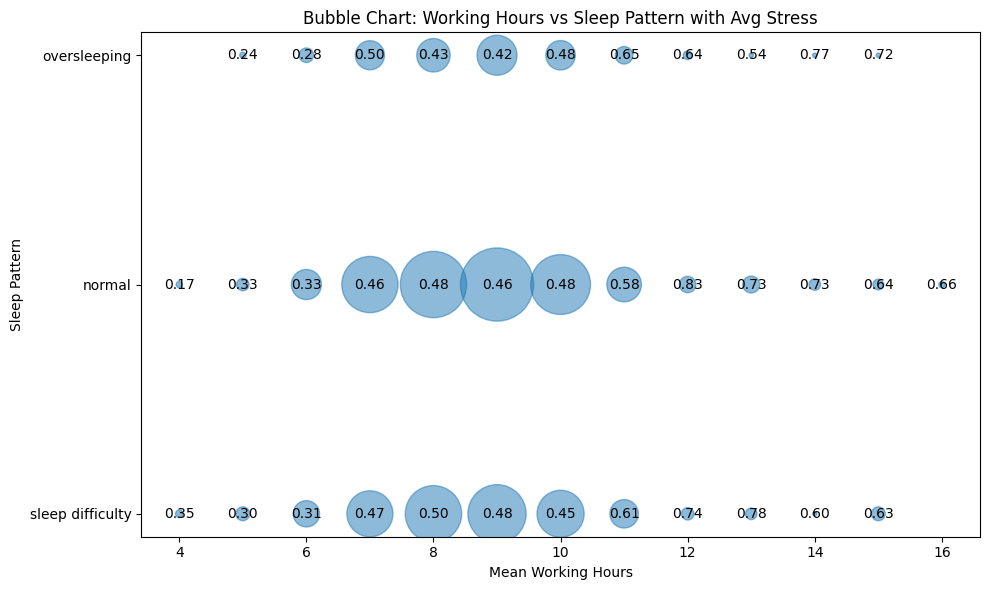

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기
train = pd.read_csv('train.csv')

# 사용할 칼럼 선택 및 결측치 제거
df = train[['mean_working', 'sleep_pattern', 'stress_score']].dropna()

# 수면 패턴을 수치로 매핑
mapping = {'sleep difficulty': 0, 'normal': 1, 'oversleeping': 2}
df['sleep_numeric'] = df['sleep_pattern'].map(mapping)

# 그룹별 개수(count)와 평균 스트레스(avg_stress) 계산
grouped = (
    df.groupby(['mean_working', 'sleep_pattern'])
      .agg(count=('stress_score','size'),
           avg_stress=('stress_score','mean'))
      .reset_index()
)
grouped['sleep_numeric'] = grouped['sleep_pattern'].map(mapping)

# 버블 차트 그리기
plt.figure(figsize=(10, 6))
plt.scatter(
    grouped['mean_working'], 
    grouped['sleep_numeric'], 
    s=grouped['count'] * 10,  # bubble 크기 조정
    alpha=0.5
)

# 버블 안에 평균 스트레스 지수 표시
for _, row in grouped.iterrows():
    plt.text(
        row['mean_working'], 
        row['sleep_numeric'], 
        f"{row['avg_stress']:.2f}",
        ha='center', 
        va='center'
    )

plt.yticks(list(mapping.values()), list(mapping.keys()))
plt.xlabel('Mean Working Hours')
plt.ylabel('Sleep Pattern')
plt.title('Bubble Chart: Working Hours vs Sleep Pattern with Avg Stress')
plt.tight_layout()
plt.show()
